# environment check

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.__version__

'1.1.0'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

system check

In [5]:
import sys
import os

In [6]:
cwd = os.getcwd() # current path

In [7]:
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

seed settings

In [8]:
import random

In [9]:
random.seed(1)
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

# Data Load

In [10]:
from mnist import *

In [11]:
mymnist = MyMNIST()

In [12]:
import matplotlib.pyplot as plt

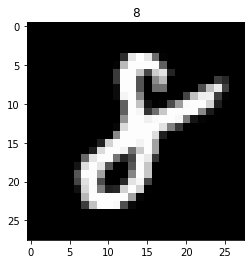

In [13]:
for X, Y in mymnist.train_data_loader:
    r = random.randint(0, mymnist.train_data_loader.batch_size)
    
    X = X[r,:]
    
    plt.imshow(X.reshape(28, 28), cmap = 'gray')
    plt.title('{}'.format(Y[r]))
    plt.show()
    break

# CNN model build

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.layer = nn.Linear(in_features=32*7*7, out_features=10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        
        out = out.view(out.size(0), -1)
        out = self.layer(out)
        
        return out

In [15]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer): Linear(in_features=1568, out_features=10, bias=True)
)

In [16]:
torch.randn(1, 28, 28).shape

torch.Size([1, 28, 28])

In [17]:
model(torch.randn(1, 1, 28, 28).to(device))

tensor([[-0.2058,  0.0408,  0.0998,  0.0690, -0.3282,  0.2268, -0.0072, -0.0580,
          0.0149, -0.0116]], device='cuda:0', grad_fn=<AddmmBackward>)

# Train model

hyperprameter

In [18]:
epochs = 10
learning_rate = 1e-3
batch_size = mymnist.train_data_loader.batch_size
total_batch = len(mymnist.train_data_loader)

loss function 

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train model

In [20]:
model.train()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer): Linear(in_features=1568, out_features=10, bias=True)
)

In [21]:
%%time
for i in range(epochs):
    avg_loss = 0
    for X, Y in mymnist.train_data_loader:
        X = X.view(-1, 1, 28, 28).to(device)
        Y = Y.to(device)
        out = model(X)
        
        loss = criterion(out, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss / total_batch
    
    print('[Epoch: {:>4}] cost = {:>.9}'.format(i + 1, avg_loss))

[Epoch:    1] cost = 0.332181007
[Epoch:    2] cost = 0.0875096768
[Epoch:    3] cost = 0.0631829053
[Epoch:    4] cost = 0.0507494174
[Epoch:    5] cost = 0.0435043909
[Epoch:    6] cost = 0.0389000922
[Epoch:    7] cost = 0.0336422808
[Epoch:    8] cost = 0.0295381472
[Epoch:    9] cost = 0.0263337921
[Epoch:   10] cost = 0.0243617184
Wall time: 1min 19s


# Test Model

In [22]:
data_len = len(mymnist.mnist_test)
data_len

10000

In [23]:
with torch.no_grad():
    model.eval()
    
    total_acc = 0
    
    for X, Y in mymnist.test_data_loader:
        X = X.view(-1, 1, 28, 28).to(device)
        Y = Y.to(device)
        
        prediction = model(X)
        correct_prediction = torch.argmax(prediction, 1) == Y
        
        total_acc += sum(correct_prediction.float()) / data_len
    
    print('Accuracy: {:.2f}%'.format(total_acc.cpu().numpy()*100))

Accuracy: 98.77%


# CNN model save & load

save path settings

In [24]:
PATH = os.path.join(cwd , './cnn_weights/')

if os.path.exists(PATH):
    print('Already exists')
else:
    os.makedirs(PATH)

Already exists


## method 1

In [25]:
torch.save(model, PATH + '/model.pt')  # total model save

C:\ProgramData\Anaconda3\envs\pytorch36\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


model check

In [26]:
saved_model = torch.load(PATH + '/model.pt')

In [27]:
saved_model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer): Linear(in_features=1568, out_features=10, bias=True)
)

weights check

In [28]:
model.conv1.weight.data[0]

tensor([[[-0.0091,  0.4490,  0.3716],
         [ 0.4865,  0.1156,  0.3430],
         [ 0.1296, -0.2419, -0.4784]]], device='cuda:0')

In [29]:
saved_model.conv1.weight.data[0]

tensor([[[-0.0091,  0.4490,  0.3716],
         [ 0.4865,  0.1156,  0.3430],
         [ 0.1296, -0.2419, -0.4784]]], device='cuda:0')

In [30]:
with torch.no_grad():
    saved_model.eval()
    
    total_acc = 0
    
    for X, Y in mymnist.test_data_loader:
        X = X.view(-1, 1, 28, 28).to(device)
        Y = Y.to(device)
        
        prediction = saved_model(X)
        correct_prediction = torch.argmax(prediction, 1) == Y
        
        total_acc += sum(correct_prediction.float()) / data_len
    
    print('Accuracy: {:.2f}%'.format(total_acc.cpu().numpy()*100))

Accuracy: 98.77%


## method 2

In [31]:
torch.save(model.state_dict(), PATH + '/model_state_dict.pt')  # state_dict save

In [32]:
saved_model2 = CNN().to(device)

In [33]:
saved_model2.load_state_dict(torch.load(PATH + '/model_state_dict.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [34]:
saved_model2.conv1.weight.data[0]

tensor([[[-0.0091,  0.4490,  0.3716],
         [ 0.4865,  0.1156,  0.3430],
         [ 0.1296, -0.2419, -0.4784]]], device='cuda:0')

check model

In [35]:
with torch.no_grad():
    saved_model2.eval()
    
    total_acc = 0
    
    for X, Y in mymnist.test_data_loader:
        X = X.view(-1, 1, 28, 28).to(device)
        Y = Y.to(device)
        
        prediction = saved_model2(X)
        correct_prediction = torch.argmax(prediction, 1) == Y
        
        total_acc += sum(correct_prediction.float()) / data_len
    
    print('Accuracy: {:.2f}%'.format(total_acc.cpu().numpy()*100))

Accuracy: 98.77%


## method 3

In [36]:
torch.save({
    'epoch': epochs,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': avg_loss
}, PATH + '/all.tar')  # hyperparameter + parameters save

In [37]:
saved_model3 = CNN().to(device)
optimizer = optim.Adam(saved_model3.parameters())

In [38]:
checkpoint = torch.load(PATH + '/all.tar')   # dict 불러오기
saved_model3.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [39]:
epoch

10

In [40]:
loss

tensor(0.0244, device='cuda:0', requires_grad=True)

In [41]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

check model

In [42]:
with torch.no_grad():
    saved_model3.eval()
    
    total_acc = 0
    
    for X, Y in mymnist.test_data_loader:
        X = X.view(-1, 1, 28, 28).to(device)
        Y = Y.to(device)
        
        prediction = saved_model3(X)
        correct_prediction = torch.argmax(prediction, 1) == Y
        
        total_acc += sum(correct_prediction.float()) / data_len
    
    print('Accuracy: {:.2f}%'.format(total_acc.cpu().numpy()*100))

Accuracy: 98.77%
